In [1]:
import numpy as np
import cv2
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
#from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from sklearn.model_selection import StratifiedKFold


In [2]:
train_data =r"C:\Users\91968\Desktop\Dive Into DL\covid_1"

In [3]:
os.listdir(train_data)

['COVID', 'NORMAL']

In [4]:
train_df = []
sizes=[]

for directory in os.listdir(train_data):
    path = os.path.join(train_data, directory)
    if not os.path.isdir(path):
        continue
    for item in os.listdir(path):
        img = cv2.imread(os.path.join(path, item))
        #img = cv2.cvtColor(img,  cv2.COLOR_BGR2GRAY)
        #img = cv2.resize(img, (224, 224))
        train_df.append([img, directory])
        sizes.append(img.shape)

In [61]:
print('total instances in train_df : ',len(train_df))
print('shape of x-ray image : ',train_df[0][0].shape)

total instances in train_df :  1836
shape of x-ray image :  (299, 299, 3)


In [5]:
y_train=[]
X_train=[]

for x,y in train_df:
    X_train.append(x)
    y_train.append(y)
    

for i in range(len(y_train)):
    if y_train[i]=='NORMAL':
        y_train[i]=0
    else:
        y_train[i]=1
        
        
X_train=np.array(X_train)
y_train=np.array(y_train)


X_train=X_train/255

print(X_train.shape)
print(y_train.shape)

# X_train=X_train.reshape(len(X_train),224,224,1)
# print('Shape : ' , X_train.shape)


(1836, 299, 299, 3)
(1836,)


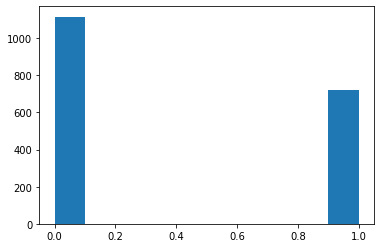

In [6]:
plt.hist(y_train);

In [26]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

553476096/553467096 [==============================] - 52s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [7]:
def AlexNet():
    return tf.keras.models.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of
        # the output. Here, the number of output channels is much larger than
        # that in LeNet
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=76,input_shape=(299,299,3),
                               activation='relu'),
        
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        tf.keras.layers.Dense(1,activation='sigmoid')])

In [8]:
model_2=AlexNet()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1109056   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 96)        743520    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 384)       1

In [9]:
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:

accuracy=[]
skf=StratifiedKFold(n_splits=5,random_state=None)
skf.get_n_splits(X_train,y_train)
for train_index,test_index in skf.split(X_train,y_train):
    print('train :' ,train_index ,'validation :', test_index)
    X1_train,X1_test=X_train[train_index],X_train[test_index]
    y1_train,y1_test=y_train[train_index],y_train[test_index]
    
    
    history=model_2.fit(X1_train,y1_train,
                    epochs=10,
                    batch_size=64,
                    #validation_data=(X_test,y_test),
                    #class_weight=class_weight,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=1,mode='auto')]   
                 )
    
    prediction=model_2.predict(X1_test)
    score=accuracy_score(prediction,y1_test)
    accuracy.append(score)
    

train : [ 144  145  146 ... 1833 1834 1835] validation : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 80